In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
seqerrors = {x.split("__")[-1].split(".")[0]:pd.read_csv(x, sep="\t", index_col=0) for x in glob.glob("../data/ww_dump/dataframes/seqerrors__*")}
pcrerrors = {x.split("__")[-1].split(".")[0]:pd.read_csv(x, sep="\t", index_col=0) for x in glob.glob("../data/ww_dump/dataframes/pcrerrors__*")}
hifreqerrors = {x.split("__")[-1].split(".")[0]:pd.read_csv(x, sep="\t", index_col=0) for x in glob.glob("../data/ww_dump/dataframes/hifreqerrors__*")}

vcfs = {x.split("__")[-1].split(".")[0]:pd.read_csv(x, sep="\t", index_col=0) for x in glob.glob("../data/ww_dump/dataframes/vcf_*")}

for x in seqerrors.values():
    x = x.rename({"REF":"NUC_COUNT"})

In [41]:
def add_col_rates(df, stop=True):
    for x in "ACGT":
        df[f"TO_{x}_RATE"] = df[f"TO_{x}"] / df["NUC_COUNT"]
    if stop:
        for x in "ACGT":
            df[f"TO_{x}_STOP_RATE"] = df[f"TO_{x}_STOP"] / (df[f"{x}_STOP"] + 0.00001)
        
def get_total_rate(df, stop=True):
    if stop:
        stop="_STOP"
        return sum([sum(df[f"TO_{x}{stop}"]) for x in "ACGT"]) / sum([sum(df[f"{x}{stop}"]) for x in "ACGT"])
    else:
        stop=""
        return sum([sum(df[f"TO_{x}{stop}"]) for x in "ACGT"]) / sum(df[f"NUC_COUNT"])
    

def vectorise_rates(df, stop=True):
    if stop:
        stop="STOP_"
    else:
        stop=""
    return np.hstack(tuple(np.array(df[f"TO_{x}_{stop}RATE"]) for x in "ACGT"))


def get_total_bases(df):
    return sum(df["DEPTH"])

In [53]:
for x in pcrerrors.values():
    add_col_rates(x)
    
for x in hifreqerrors.values():
    add_col_rates(x, stop=False)
    
for x in seqerrors.values():
    add_col_rates(x, stop=False)

In [63]:
rates = [vectorise_rates(v) for v in pcrerrors.values()]
rates = [x for x in rates if len(x) == 16]
rates = np.array(rates)

all_rates = [vectorise_rates(v, stop=False) for v in hifreqerrors.values()]
all_rates = [x for x in all_rates if len(x) == 16]
all_rates = np.array(all_rates)

seq_rates = [vectorise_rates(v, stop=False) for v in seqerrors.values()]
seq_rates = [x for x in seq_rates if len(x) == 16]
seq_rates = np.array(seq_rates)

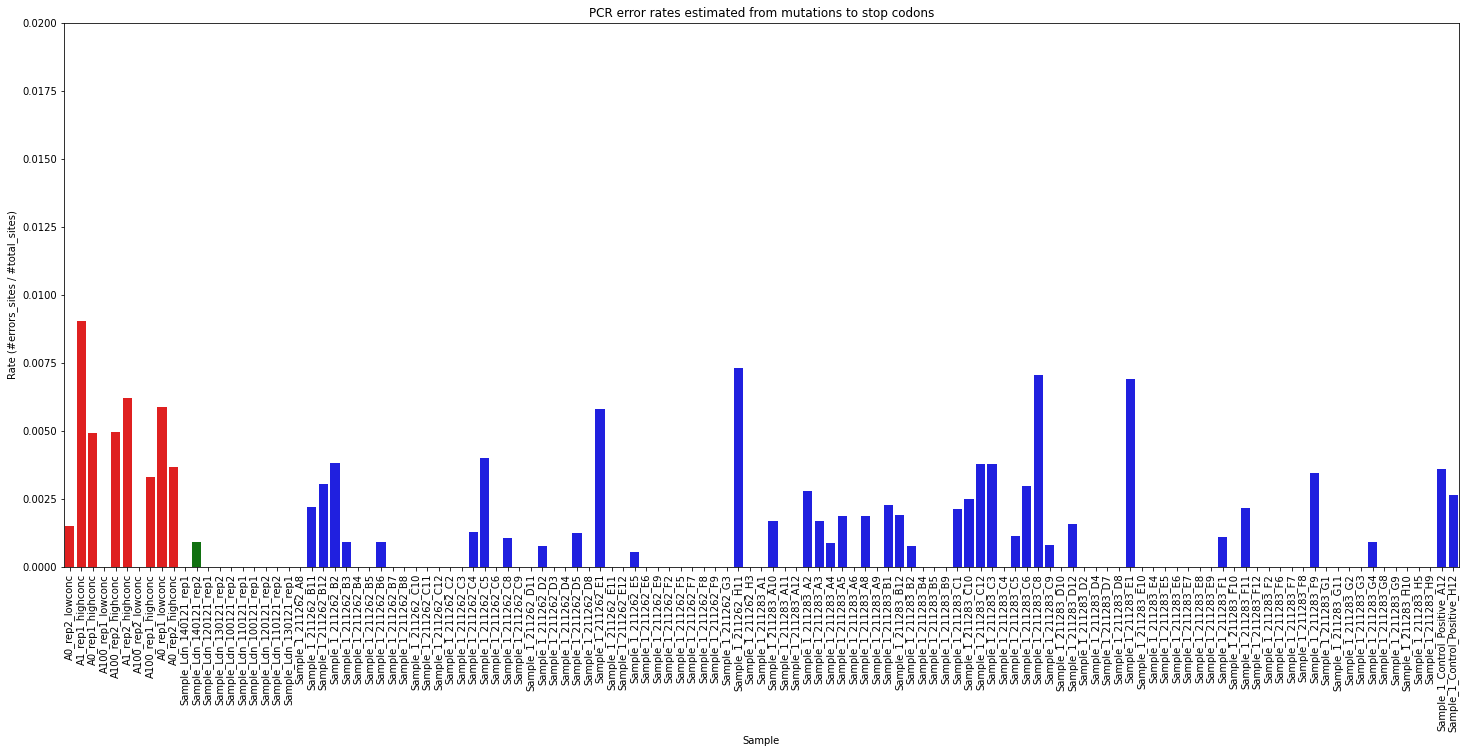

In [55]:
total_stop_rates = {k: get_total_rate(v) for k,v in pcrerrors.items()}
keys = list(total_stop_rates.keys())
keys0 = [x for x in keys if x[0] == "A"]
keys1 = [x for x in keys if x.split("_")[1] == "Ldn"]
keys2 = [x for x in keys if not x in keys1 and not x in keys0]
keys2.sort()
keys = keys0 + keys1 + keys2
palette = ["red"] * len(keys0) + ["green"] * len(keys1) + ["blue"] * len(keys2)
plt.figure(figsize=(25, 10))
#sns.barplot(x=keys, y=[total_rates[k] for k in keys])
bp = sns.barplot(x=keys, y=[total_stop_rates[k] for k in keys], palette=palette)
bp.set_xticklabels(keys,rotation=90)
bp.set_title("PCR error rates estimated from mutations to stop codons")
bp.set_xlabel("Sample")
bp.set_ylabel("Rate (#errors_sites / #total_sites)")
bp.set_ylim(0, 0.02)
pass

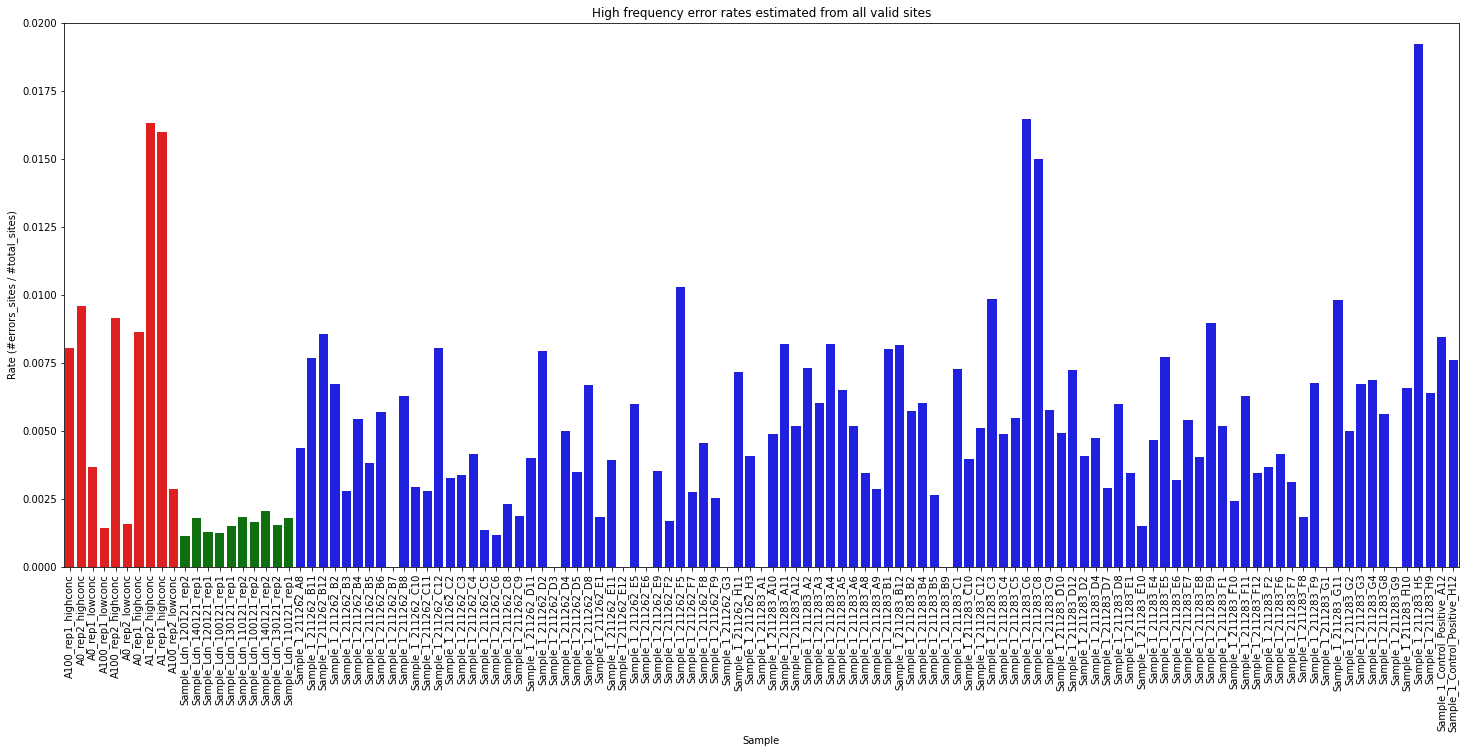

In [56]:
total_rates = {k: get_total_rate(v, stop=False) for k,v in hifreqerrors.items()}
keys = list(total_rates.keys())
keys0 = [x for x in keys if x[0] == "A"]
keys1 = [x for x in keys if x.split("_")[1] == "Ldn"]
keys2 = [x for x in keys if not x in keys1 and not x in keys0]
keys2.sort()
keys = keys0 + keys1 + keys2
palette = ["red"] * len(keys0) + ["green"] * len(keys1) + ["blue"] * len(keys2)
plt.figure(figsize=(25, 10))
#sns.barplot(x=keys, y=[total_rates[k] for k in keys])
bp = sns.barplot(x=keys, y=[total_rates[k] for k in keys], palette=palette)
bp.set_xticklabels(keys,rotation=90)
bp.set_title("High frequency error rates estimated from all valid sites")
bp.set_xlabel("Sample")
bp.set_ylabel("Rate (#errors_sites / #total_sites)")
bp.set_ylim(0, 0.02)
pass

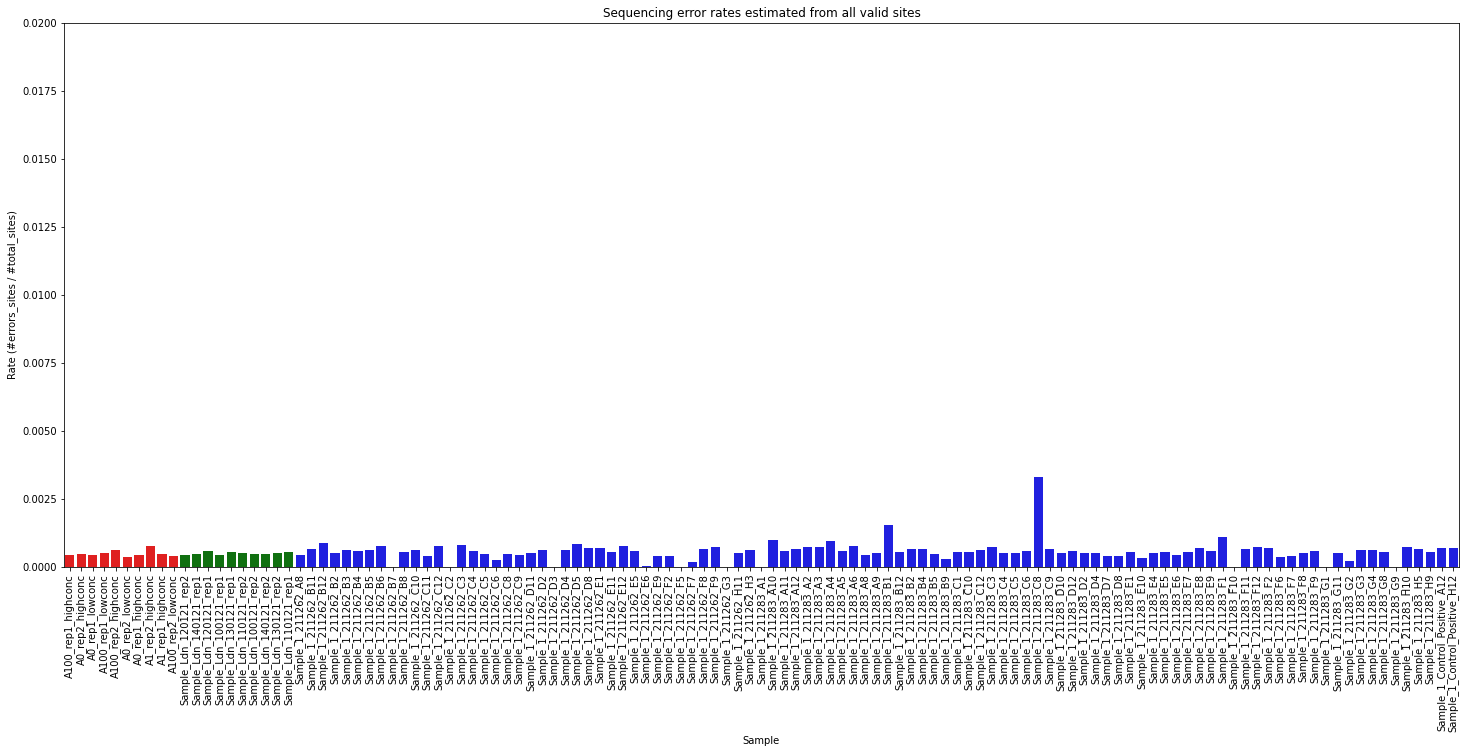

In [64]:
seq_rates_dict = {k: get_total_rate(v, stop=False) for k,v in seqerrors.items()}
keys = list(total_rates.keys())
keys0 = [x for x in keys if x[0] == "A"]
keys1 = [x for x in keys if x.split("_")[1] == "Ldn"]
keys2 = [x for x in keys if not x in keys1 and not x in keys0]
keys2.sort()
keys = keys0 + keys1 + keys2
palette = ["red"] * len(keys0) + ["green"] * len(keys1) + ["blue"] * len(keys2)
plt.figure(figsize=(25, 10))
#sns.barplot(x=keys, y=[total_rates[k] for k in keys])
bp = sns.barplot(x=keys, y=[seq_rates_dict[k] for k in keys], palette=palette)
bp.set_xticklabels(keys,rotation=90)
bp.set_title("Sequencing error rates estimated from all valid sites")
bp.set_xlabel("Sample")
bp.set_ylabel("Rate (#errors_sites / #total_sites)")
bp.set_ylim(0, 0.02)
pass

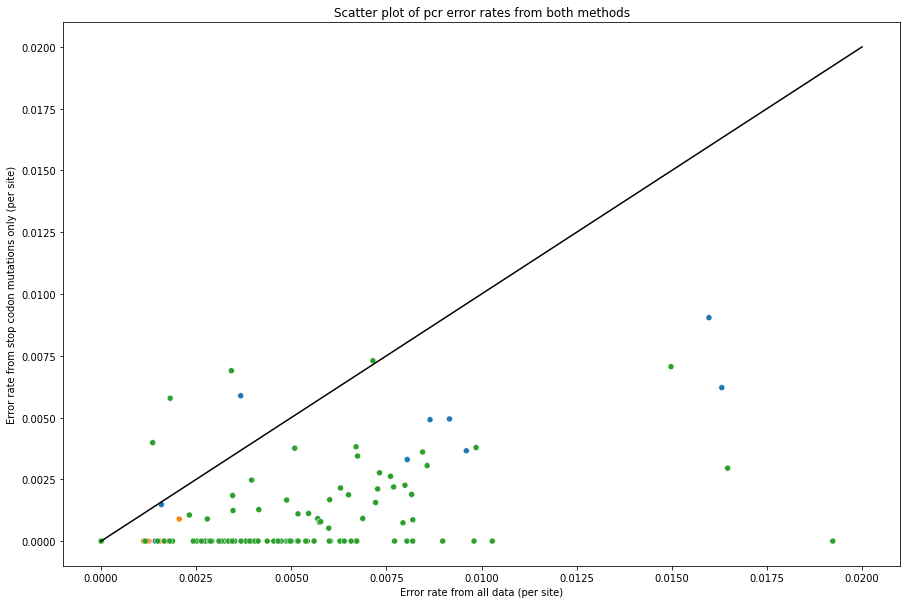

In [65]:
fig = plt.figure(figsize=(15, 10))
ax = sns.scatterplot(x=[total_rates[k] for k in keys], y=[total_stop_rates[k] for k in keys], hue=palette)
ax = sns.lineplot(x=np.linspace(0, 0.02, 100), y=np.linspace(0, 0.02, 100), color="black")
ax.set_title("Scatter plot of pcr error rates from both methods")
ax.set_xlabel("Error rate from all data (per site)")
ax.set_ylabel("Error rate from stop codon mutations only (per site)")
ax.legend([], [],  frameon=False)

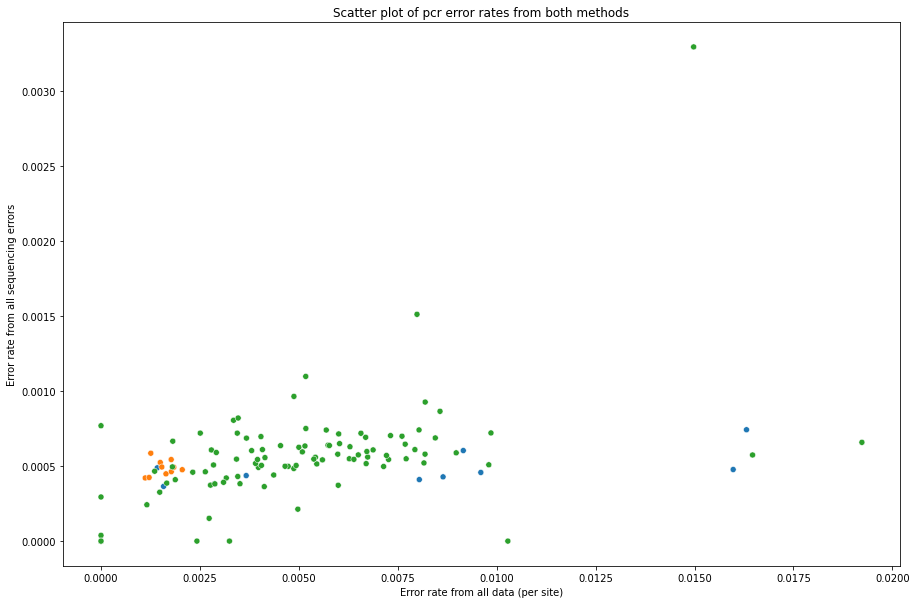

In [85]:
fig = plt.figure(figsize=(15, 10))
ax = sns.scatterplot(x=[total_rates[k] for k in keys], y=[seq_rates_dict[k] for k in keys], hue=palette)
#ax = sns.lineplot(x=np.linspace(0, 0.02, 100), y=np.linspace(0, 0.02, 100), color="black")
ax.set_title("Scatter plot of pcr error rates from both methods")
ax.set_xlabel("Error rate from all data (per site)")
ax.set_ylabel("Error rate from all sequencing errors")
ax.legend([], [],  frameon=False)

In [67]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
y = pca.fit_transform(rates)
z = pca.transform(all_rates)
w = pca.transform(seq_rates)

print(pca.explained_variance_ratio_)

print(pca.singular_values_)

[0.83367391 0.07717863]
[0.11712414 0.03563665]


<AxesSubplot:>

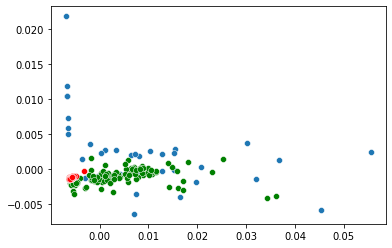

In [73]:
sns.scatterplot(x=y[:,0], y=y[:,1])
sns.scatterplot(x=z[:,0], y=z[:,1], color="green")
sns.scatterplot(x=w[:,0], y=w[:,1], color="red")

In [74]:
pd.DataFrame(np.mean(rates, axis=0).reshape(4,4).T)

,0,1,2,3
0,0.000000,0.0,0.00000,0.000084
1,0.000383,0.0,0.00023,0.000796
2,0.000112,0.0,0.00000,0.006284
3,0.000139,0.0,0.00128,0.000000


In [75]:
pd.DataFrame(np.mean(all_rates, axis=0).reshape(4,4).T)

,0,1,2,3
0,0.000000,0.001714,0.000406,0.000778
1,0.002081,0.000000,0.000209,0.003089
2,0.001911,0.000944,0.000000,0.009831
3,0.000786,0.000745,0.000603,0.000000


In [76]:
pd.DataFrame(np.mean(seq_rates, axis=0).reshape(4,4).T)

,0,1,2,3
0,0.000000,0.000167,0.000139,0.000149
1,0.000389,0.000000,0.000061,0.000179
2,0.000203,0.000058,0.000000,0.000435
3,0.000164,0.000141,0.000177,0.000000


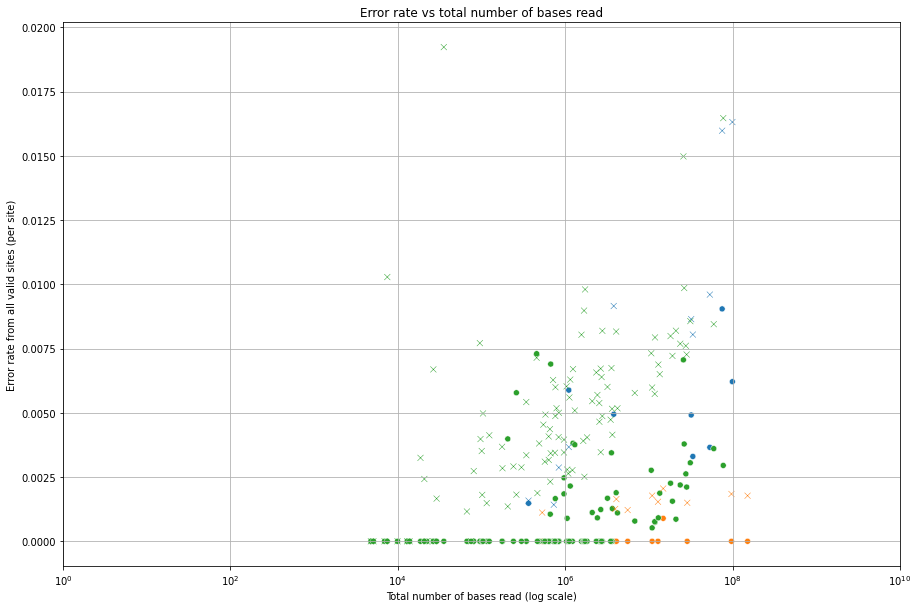

In [89]:
plt.figure(figsize=(15, 10))
plt.grid()
plt.xlim(1, 1e10)
plt.xscale("log")
ax = sns.scatterplot(x=[1 + total_bases[k] for k in keys], y=[total_stop_rates[k] for k in keys], hue=palette)
ax = sns.scatterplot(x=[1 + total_bases[k] for k in keys], y=[total_rates[k] for k in keys], hue=palette, marker="x")
#ax = sns.scatterplot(x=[1 + total_bases[k] for k in keys], y=[seq_rates_dict[k] for k in keys], hue=palette, marker="*")
ax.set_title("Error rate vs total number of bases read")
ax.set_xlabel("Total number of bases read (log scale)")
ax.set_ylabel("Error rate from all valid sites (per site)")
ax.legend([], [],  frameon=False)

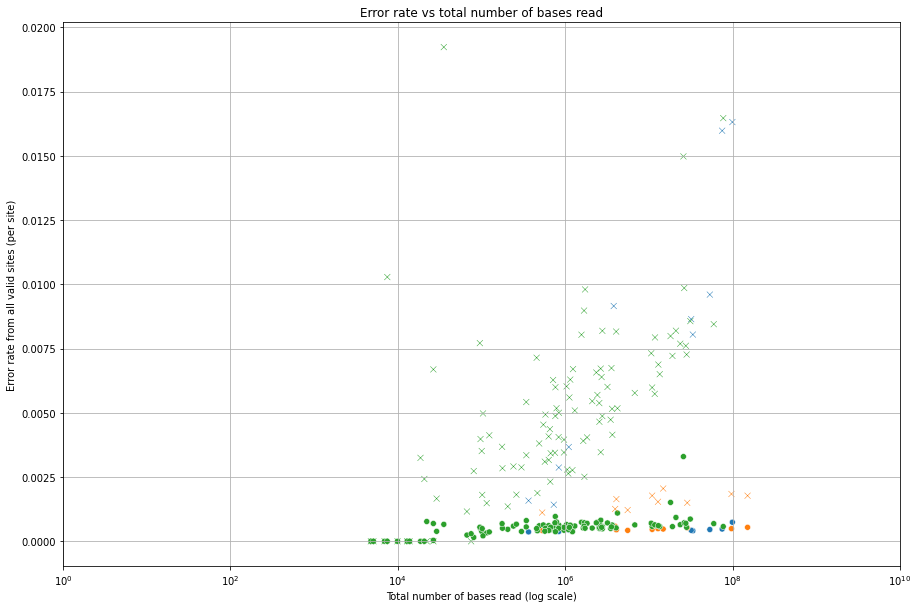

In [84]:
plt.figure(figsize=(15, 10))
plt.grid()
plt.xlim(1, 1e10)
plt.xscale("log")
ax = sns.scatterplot(x=[1 + total_bases[k] for k in keys], y=[seq_rates_dict[k] for k in keys], hue=palette)
ax = sns.scatterplot(x=[1 + total_bases[k] for k in keys], y=[total_rates[k] for k in keys], hue=palette, marker="x")
ax.set_title("Error rate vs total number of bases read")
ax.set_xlabel("Total number of bases read (log scale)")
ax.set_ylabel("Error rate from all valid sites (per site)")
ax.legend([], [],  frameon=False)

In [170]:
ERROR_CUTOFF = 0.02
def filter_for_pcr_errors(df):
    df2 = df.where(df["DEPTH"] >= 10).dropna()
    df2 = df2.where(
        ((df2["POS"] > 300) & (df2["POS"] < 12000)) | 
        ((df2["POS"] > 13500) & (df2["POS"] < 20000)) | 
        ((df2["POS"] > 21600) & (df2["POS"] < 25000))
    ).dropna()
    df2 = df2.where(df2["ERROR_PC"] >= ERROR_CUTOFF).dropna()
    df2["TO_A"] = df2.apply(lambda y: 1 if y.MUT_TO_A/y.DEPTH > ERROR_CUTOFF and y.MUT_TO_A > 5 else 0 ,axis=1)
    df2["TO_C"] = df2.apply(lambda y: 1 if y.MUT_TO_C/y.DEPTH > ERROR_CUTOFF and y.MUT_TO_C > 5 else 0 ,axis=1)
    df2["TO_G"] = df2.apply(lambda y: 1 if y.MUT_TO_G/y.DEPTH > ERROR_CUTOFF and y.MUT_TO_G > 5 else 0 ,axis=1)
    df2["TO_T"] = df2.apply(lambda y: 1 if y.MUT_TO_T/y.DEPTH > ERROR_CUTOFF and y.MUT_TO_T > 5 else 0 ,axis=1)
    df2 = df2.where(
        (df2["TO_A"] * df2["A_STOP"] > 0) | 
        (df2["TO_C"] * df2["C_STOP"] > 0) | 
        (df2["TO_G"] * df2["G_STOP"] > 0) | 
        (df2["TO_T"] * df2["T_STOP"] > 0)).dropna()

    return df2


def filter_for_hifreq_errors(df):
    
    df2 = df.where(df["DEPTH"] >= 10).dropna()
    df2 = df2.where(df2["ERROR_PC"] >= ERROR_CUTOFF).dropna()
    df2["TO_A"] = df2.apply(lambda y: 1 if y.MUT_TO_A/y.DEPTH > ERROR_CUTOFF and y.MUT_TO_A > 5 else 0 ,axis=1)
    df2["TO_C"] = df2.apply(lambda y: 1 if y.MUT_TO_C/y.DEPTH > ERROR_CUTOFF and y.MUT_TO_C > 5 else 0 ,axis=1)
    df2["TO_G"] = df2.apply(lambda y: 1 if y.MUT_TO_G/y.DEPTH > ERROR_CUTOFF and y.MUT_TO_G > 5 else 0 ,axis=1)
    df2["TO_T"] = df2.apply(lambda y: 1 if y.MUT_TO_T/y.DEPTH > ERROR_CUTOFF and y.MUT_TO_T > 5 else 0 ,axis=1)

    return df2

def filter_for_seq_errors(df):
    
    df2 = df.where(df["DEPTH"] >= 10).dropna()
    df2 = df2.where(df2["ERROR_PC"] < ERROR_CUTOFF).dropna()
    return df2

def set_col(df, key):
    df["DATASET"] = key
    return df

In [172]:
pcr_vcf = {k:filter_for_pcr_errors(v) for k,v in vcfs.items()}
pcr_vcf = {k:set_col(v, k) for k,v in pcr_vcf.items()}
pcr_df = pd.concat(pcr_vcf.values(), ignore_index=True)

In [173]:
hf_vcf = {k:filter_for_hifreq_errors(v) for k,v in vcfs.items()}
hf_vcf = {k:set_col(v, k) for k,v in hf_vcf.items()}
hf_df = pd.concat(hf_vcf.values(), ignore_index=True)

In [171]:
seq_vcf = {k:filter_for_seq_errors(v) for k,v in vcfs.items()}
seq_vcf = {k:set_col(v, k) for k,v in seq_vcf.items()}
seq_df = pd.concat(seq_vcf.values(), ignore_index=True)

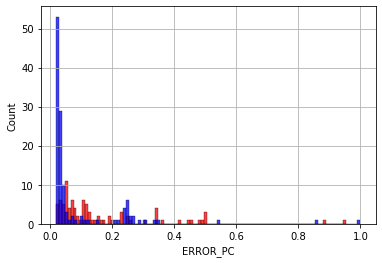

In [162]:
def error_pc_plot(df):
    ax = sns.histplot(x="ERROR_PC", data=df.where(
        df.apply(lambda x: x.DATASET[0] == "A", axis=1)).dropna(), bins=100, color="red")
    ax = sns.histplot(x="ERROR_PC", data=df.where(
        df.apply(lambda x: x.DATASET.split("_")[:2] == ["Sample","Ldn"], axis=1)).dropna(), bins=100, color="green")
    ax = sns.histplot(x="ERROR_PC", data=df.where(
        df.apply(lambda x: x.DATASET.split("_")[:2] == ["Sample","1"], axis=1)).dropna(), bins=100, color="blue")

    ax.grid()
    
error_pc_plot(pcr_df)

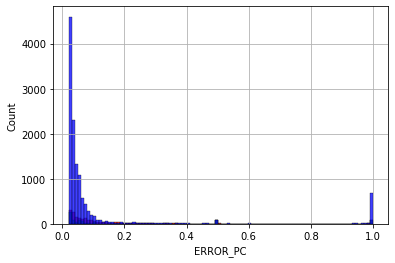

In [163]:
error_pc_plot(hf_df)

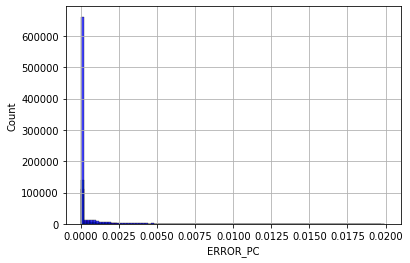

In [174]:
error_pc_plot(seq_df)

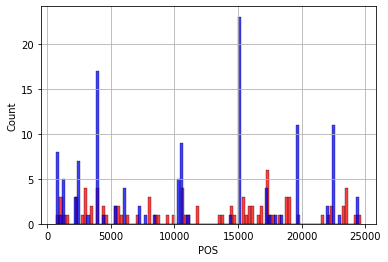

In [164]:
def pos_plot(df):
    ax = sns.histplot(x="POS", data=df.where(
        df.apply(lambda x: x.DATASET[0] == "A", axis=1)).dropna(), bins=100, color="red")
    ax = sns.histplot(x="POS", data=df.where(
        df.apply(lambda x: x.DATASET.split("_")[:2] == ["Sample","Ldn"], axis=1)).dropna(), bins=100, color="green")
    ax = sns.histplot(x="POS", data=df.where(
        df.apply(lambda x: x.DATASET.split("_")[:2] == ["Sample","1"], axis=1)).dropna(), bins=100, color="blue")
    ax.grid()
    
pos_plot(pcr_df)

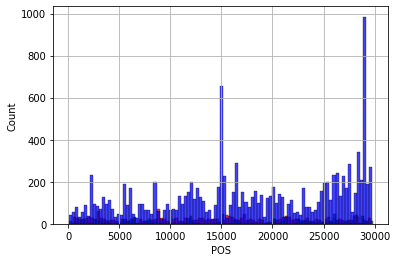

In [165]:
pos_plot(hf_df)

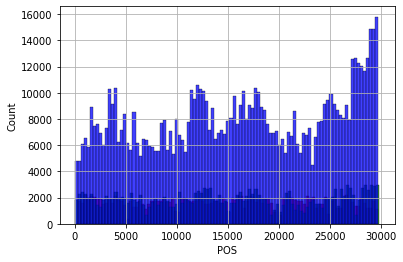

In [175]:
pos_plot(seq_df)

In [182]:
import numpy as np

In [202]:
def pcr_alt_sim(N_rounds, N_start, prob_replication, prob_err):
    start = [N_start, 0]
    for i in range(N_rounds):
        new = np.random.binomial(start[0], prob_replication)
        new_with_errors = np.random.binomial(new, prob_err)
        start[0] = start[0] + new - new_with_errors
        start[1] = start[1] + np.random.binomial(start[1], prob_replication) + new_with_errors
        
    return start[1]/(start[0] + start[1])

In [207]:
my_data = [pcr_alt_sim(25, 1, 0.9, 0.05) for i in range(100000)]

(0.0, 1.0)

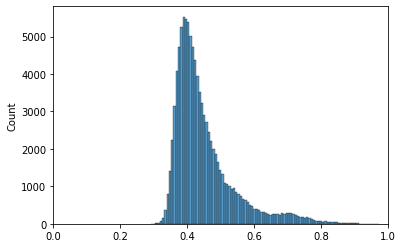

In [208]:
ax = sns.histplot(my_data, bins=100)
plt.xlim(0,1)